# Import

In [1]:
!pip install torcheval

  Obtaining dependency information for torcheval from https://files.pythonhosted.org/packages/e4/de/e7abc784b00de9d05999657d29187f1f7a3406ed10ecaf164de06482608f/torcheval-0.0.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.7 MB/s eta 0:00:00


In [2]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import warnings
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, classification_report

import transformers
import torch, torchaudio, torchtext
import torch.nn.functional as F
import torch.nn as nn

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_f1_score
from transformers import BertTokenizer, BertModel, AutoModel, AutoProcessor
from tqdm import tqdm

try:
    # try to import from local
    from CustomTransformer import CustomEncoder, PositionalEncoding, LayerNorm
except:
    # import from kaggle workspace
    from customtransformer import CustomEncoder, PositionalEncoding, LayerNorm

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.3f}'.format

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Constants

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

"""
For the Argumentative Component Classification (ACC) task, we need to remove the 'O' label from the dataset.
"""
MODEL_NUM_LABELS = 3
REMOVE_OTHER = True
OTHER_LABEL = 'O'
    
if REMOVE_OTHER:
    MODEL_NUM_LABELS = 2

TEXT_MODEL_CARD = 'bert-base-uncased'
AUDIO_MODEL_CARD = 'facebook/wav2vec2-base-960h'

LABEL_2_ID = {
    'Claim': 0,
    'Premise': 1,
    'O': 2
}

ID_2_LABEL = {
    0: 'Claim',
    1: 'Premise',
    2: 'O'
}


EMBEDDING_DIM = 768
BATCH_SIZE = 12

Using device: cuda


# Load df

In [4]:
try:
    # Try to load from Kaggle workspace
    df_path = '/kaggle/input/multimodal-argument-mining/MM-USElecDeb60to16/MM-USElecDeb60to16.csv'
    audio_path = '/kaggle/input/multimodal-argument-mining/MM-USElecDeb60to16/audio_clips'
    load_path = '/kaggle/input/mm-dataset-subsampling/'
    save_path = '/kaggle/working/'
    df = pd.read_csv(df_path, index_col=0)
except FileNotFoundError:
    # Try to load from local
    df_path = 'multimodal-dataset/files/MM-USElecDeb60to16/MM-USElecDeb60to16.csv'
    audio_path = 'multimodal-dataset/files/MM-USElecDeb60to16/audio_clips'
    load_path = 'multimodal-dataset/files'
    save_path = 'multimodal-dataset/files'
    df = pd.read_csv(df_path, index_col=0)
    
# drop rows where audio length is 0
df = df[df['NewBegin'] != df['NewEnd']]
if REMOVE_OTHER:
    # drop rows where Component is 'Other'
    df = df[df['Component'] != OTHER_LABEL]

# train, val, test split
train_df_complete = df[df['Set'] == 'TRAIN']
val_df_complete = df[df['Set'] == 'VALIDATION']
test_df_complete = df[df['Set'] == 'TEST']

# subsample datasets for memory reasons
DATASET_RATIO = 1
train_df = train_df_complete.iloc[:int(DATASET_RATIO * len(train_df_complete))]
val_df = val_df_complete.iloc[:int(DATASET_RATIO * len(val_df_complete))]
test_df = test_df_complete.iloc[:int(DATASET_RATIO * len(test_df_complete))]

In [5]:
train_df.head()

,Text,Part,Document,Order,Sentence,Start,End,Annotator,Tag,Component,...,Speaker,SpeakerType,Set,Date,Year,Name,MainTag,NewBegin,NewEnd,idClip
3,"And, after 9/11, it became clear that we had t...",1,30_2004,3,3,2418,2744,NaN,"{""O"": 16, ""Claim"": 50}",Claim,...,CHENEY,Candidate,TRAIN,05 Oct 2004,2004,Richard(Dick) B. Cheney,Claim,140.560,158.920,clip_3
4,And we also then finally had to stand up democ...,1,30_2004,4,4,2744,2974,NaN,"{""O"": 4, ""Claim"": 13, ""Premise"": 25}",Premise,...,CHENEY,Candidate,TRAIN,05 Oct 2004,2004,Richard(Dick) B. Cheney,Mixed,158.920,172.920,clip_4
9,What we did in Iraq was exactly the right thin...,1,30_2004,9,9,3861,3916,NaN,"{""Claim"": 12, ""O"": 1}",Claim,...,CHENEY,Candidate,TRAIN,05 Oct 2004,2004,Richard(Dick) B. Cheney,Claim,224.080,226.880,clip_9
10,"If I had it to recommend all over again, I wou...",1,30_2004,10,10,3916,4010,NaN,"{""Premise"": 19, ""O"": 1}",Premise,...,CHENEY,Candidate,TRAIN,05 Oct 2004,2004,Richard(Dick) B. Cheney,Premise,226.880,231.560,clip_10
11,The world is far safer today because Saddam Hu...,1,30_2004,11,11,4010,4112,NaN,"{""Claim"": 6, ""O"": 2, ""Premise"": 13}",Premise,...,CHENEY,Candidate,TRAIN,05 Oct 2004,2004,Richard(Dick) B. Cheney,Mixed,231.560,237.560,clip_11


In [6]:
print(f'Train size: {len(train_df)}')
print(f'Val size: {len(val_df)}')
print(f'Test size: {len(test_df)}')

Train size: 9455
Val size: 5201
Test size: 5908


## Distribution of classes over train df

In [7]:
num_claim = len(train_df[train_df['Component'] == 'Claim'])
print(f'Total Claim: {num_claim}: {num_claim*100/len(train_df):.2f}%')

num_premise = len(train_df[train_df['Component'] == 'Premise'])
print(f'Total Premise: {num_premise}: {num_premise*100/len(train_df):.2f}%')

if not REMOVE_OTHER:
    num_other = len(train_df[train_df['Component'] == 'O'])
    print(f'Total Other: {num_other}: {num_other*100/len(train_df):.2f}%')

Total Claim: 5029: 53.19%
Total Premise: 4426: 46.81%


Classes are not balanced, but not too bad either.

## Class Reweighting

In [8]:
if MODEL_NUM_LABELS == 2:
    claim_ratio = num_claim / (num_claim + num_premise)
    premise_ratio = num_premise / (num_claim + num_premise)
    weight = torch.tensor([1/(2*claim_ratio), 1/(2*premise_ratio)]).to(device)
else:
    claim_ratio = num_claim / (num_claim + num_premise + num_other)
    premise_ratio = num_premise / (num_claim + num_premise + num_other)
    other_ratio = num_other / (num_claim + num_premise + num_other)
    weight = torch.tensor([1/(3*claim_ratio), 1/(3*premise_ratio), 1/(3*other_ratio)]).to(device)

print(f'Weight for loss function: {weight}')

Weight for loss function: tensor([0.9400, 1.0681], device='cuda:0')


# Train and evaluation Loop

In [9]:
class BestModel:
    """
    Class to keep track of the best performing model on validation set during training
    """
    def __init__(self):
        self.best_validation_loss = float('Infinity')
        self.best_state_dict = None
    def __call__(self, model, loss):
        if loss < self.best_validation_loss:
            self.best_validation_loss = loss
            self.best_state_dict = copy.deepcopy(model.state_dict())

def evaluate(model, data_loader, loss_fn, debug=False):
    """
    Evaluate the model on the set passed
    Args:
        model: model to evaluate
        data_loader: DataLoader object
        loss_fn: loss function to use
        debug: whether to print debug statements
    """
    model.eval()
    valid_loss = 0.0
    num_correct = 0 
    num_examples = 0
    tot_pred, tot_targ = torch.LongTensor().to(device), torch.LongTensor().to(device)
    for batch in data_loader:
        texts, audio_features, audio_attention, targets = batch
        audio_features = audio_features.to(device)
        audio_attention = audio_attention.to(device)
        targets = targets.to(device)
        output = model(texts,audio_features,audio_attention)
        if debug:
            print("OUTPUT",output)
            print("TARGETS", targets)
        loss = loss_fn(output, targets)
        valid_loss += loss.detach()
        
        # if label O is still in the dataset we remove it from the outputs
        # since it's a binary task
        if not REMOVE_OTHER:
            not_other = targets != 2
            output = output[not_other]
            targets = targets[not_other]
        
        predicted_labels = torch.argmax(output[:, :2], dim=-1)
        tot_targ = torch.cat((tot_targ, targets))
        tot_pred = torch.cat((tot_pred, predicted_labels))            
        correct = torch.eq(predicted_labels, targets).view(-1)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    valid_loss = valid_loss.cpu().item()
    valid_loss /= len(data_loader.dataset)
    accuracy = num_correct/num_examples
    f1 = multiclass_f1_score(tot_pred, tot_targ, num_classes=2, average="macro")
    return valid_loss, accuracy, f1, tot_pred, tot_targ

            
def train(model, loss_fn, train_loader, val_loader, epochs=10, device="cuda", lr=1e-3, lr_decay_factor=0.1, lr_decay_patience=3, weight_decay=1e-5, verbose=True, debug=False):
    """
    Train the model on the train set and evaluate on the validation set with the given parameters
    Args:
        model: model to train
        loss_fn: loss function to use
        train_loader: DataLoader object for train set
        val_loader: DataLoader object for validation set
        epochs: number of epochs
        device: device to use
        lr: initial learning rate
        lr_decay_factor: factor to decay learning rate
        lr_decay_patience: patience for learning rate decay
        weight_decay: weight decay
        verbose: whether to print training results
        debug: whether to print debug statements
    """
    # set up optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay_factor, patience=lr_decay_patience, verbose=True)
    best_model_tracker = BestModel()
    for epoch in tqdm(range(epochs)):
        training_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            texts, audio_features, audio_attention, targets = batch
            audio_features = audio_features.to(device)
            audio_attention = audio_attention.to(device)
            targets = targets.to(device)
            output = model(texts,audio_features,audio_attention)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.detach()
        training_loss = training_loss.cpu().item()
        training_loss /= len(train_loader.dataset)
        valid_loss, accuracy, f1, _, _ = evaluate(model, val_loader, loss_fn, debug)
        best_model_tracker(model, valid_loss)
        scheduler.step(valid_loss)
        if verbose:
            print(f'Epoch: {epoch}, Training Loss: {training_loss:.4f}, Validation Loss: {valid_loss:.4f}, accuracy = {accuracy:.4f}, F1={f1:.4f}')
    # restore best model weights
    model.load_state_dict(best_model_tracker.best_state_dict) 
    return model

# Dataset Creation

In [10]:
# set up tokenizer and model
tokenizer = BertTokenizer.from_pretrained(TEXT_MODEL_CARD)
embedder = BertModel.from_pretrained(TEXT_MODEL_CARD).to(device)

# freeze bert layers
for params in embedder.parameters():
    params.requires_grad = False

# Downsample audio features to 1/5 of the original size to fit in memory
DOWNSAMPLE_FACTOR = 1/5

class MM_Dataset(torch.utils.data.Dataset):
    """
    Dataset class for multimodal dataset
    """
    def __init__(self, df, audio_dir, sample_rate):
        """
        Args:
            df: dataframe containing the dataset
            audio_dir: directory containing the audio clips
            sample_rate: sample rate to use for audio clips
        """
        self.audio_dir = audio_dir
        self.sample_rate = sample_rate

        self.audio_processor = AutoProcessor.from_pretrained(AUDIO_MODEL_CARD)
        self.audio_model = AutoModel.from_pretrained(AUDIO_MODEL_CARD).to(device)

        self.dataset = []

        # Iterate over df
        for _, row in tqdm(df.iterrows()):
            path = os.path.join(self.audio_dir, f"{row['Document']}/{row['idClip']}.wav")
            if os.path.exists(path):
                # obtain audio WAV2VEC features
                audio, sampling_rate = torchaudio.load(path)
                # resample audio if necessary
                if sampling_rate != self.sample_rate:
                    audio = torchaudio.functional.resample(audio, sample_rate, self.sample_rate)
                    # mean pooling over channels
                    audio = torch.mean(audio, dim=0, keepdim=True)
                with torch.inference_mode():
                    # run audio through model
                    input_values = self.audio_processor(audio, sampling_rate=self.sample_rate).input_values[0]
                    input_values = torch.tensor(input_values).to(device)
                    audio_model_output = self.audio_model(input_values)
                    audio_features = audio_model_output.last_hidden_state[0].unsqueeze(0)
                    # downsample audio features
                    audio_features = torch.nn.functional.interpolate(audio_features.permute(0,2,1), scale_factor=DOWNSAMPLE_FACTOR, mode='linear')
                    audio_features = audio_features.permute(0,2,1)[0]
                    audio_features = audio_features.cpu()
                
                text = row['Text']

                self.dataset.append((text, audio_features, LABEL_2_ID[row['Component']]))
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return self.dataset[index]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [11]:
try:
    # try to restore datasets from memory
    train_dataset = torch.load(f'{load_path}/train_dataset.pkl')
    test_dataset = torch.load(f'{load_path}/test_dataset.pkl')
    val_dataset = torch.load(f'{load_path}/val_dataset.pkl')
    if REMOVE_OTHER:
        train_dataset = list(filter(lambda x: x[2] != 2, train_dataset))
        test_dataset = list(filter(lambda x: x[2] != 2, test_dataset))
        val_dataset = list(filter(lambda x: x[2] != 2, val_dataset))
    print('Restored datasets from memory')
except:
    # create new datasets
    print('Creating new datasets')
    train_dataset = MM_Dataset(train_df, audio_path, 16_000)
    test_dataset = MM_Dataset(test_df, audio_path, 16_000)
    val_dataset = MM_Dataset(val_df, audio_path, 16_000)

Restored datasets from memory


## Dataloader creation

In [12]:
def create_dataloader(dataset, batch_size):
    """
    Create a DataLoader object from the given dataset with the given batch size
    Args:
        dataset: dataset to use
        batch_size: batch size to use
    """
    def pack_fn(batch):
        """
        Function to pad the audio features and create the attention mask
        """
        texts = [x[0] for x in batch]
        audio_features = [x[1] for x in batch]
        labels = torch.tensor([x[2] for x in batch])
        
        # pad audio features
        audio_features = pad_sequence(audio_features, batch_first=True, padding_value=float('-inf'))
        audio_features_attention_mask = audio_features[:, :, 0] != float('-inf')
        audio_features[(audio_features == float('-inf'))] = 0
        return texts, audio_features, audio_features_attention_mask, labels

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pack_fn)
    return dataloader

In [13]:
train_dataloader = create_dataloader(train_dataset, BATCH_SIZE)
val_dataloader = create_dataloader(val_dataset, BATCH_SIZE)
test_dataloader = create_dataloader(test_dataset, BATCH_SIZE)

In [14]:
gc.collect()

9

In [15]:
def number_parameters(model):
    """
    Computes the number of trainable parameters in the model
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 0-A Text-Only

In [26]:
class TextModel(nn.Module):
    """
    Class for the text-only model
    """
    def __init__(self, tokenizer, embedder, head):
        """
        Args:
            tokenizer: tokenizer to use
            embedder: embedder to use
            head: head to use
        """
        super().__init__()
        self.tokenizer = tokenizer
        self.embedder = embedder
        self.head = head
    def forward(self, texts, audio_features, audio_attention):
        """
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        tokenizer_output = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=False).to(device)
        embedder_output = self.embedder(**tokenizer_output, output_hidden_states=True)
        text_features = embedder_output['last_hidden_state']

        # pooling transformer output
        text_features_sum = (text_features * tokenizer_output.attention_mask.unsqueeze(-1)).sum(axis=1)
        text_features_pooled = text_features_sum / tokenizer_output.attention_mask.sum(axis=1).unsqueeze(-1)
        return self.head(text_features_pooled)

# 0-B Audio-Only

In [27]:
class AudioModel(nn.Module):        
    """
    Class for the audio-only model
    """
    def __init__(self, transformer, head, dropout_prob=0.1):
        """
        Args:
            transformer: transformer to use
            head: head to use
        """
        super().__init__()
        self.pos_encoder = PositionalEncoding(EMBEDDING_DIM, dual_modality=False)
        self.transformer = transformer
        self.head = head
        self.ln = LayerNorm(EMBEDDING_DIM)
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, texts, audio_features, audio_attention):
        global hard_debug
        """
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        padding_mask = ~audio_attention.to(torch.bool)        
        full_attention_mask = torch.zeros((audio_features.shape[1],audio_features.shape[1]), dtype=torch.bool).to(device)
        
        audio_features = self.pos_encoder(audio_features)
        
        transformer_output = self.transformer(audio_features, mask=full_attention_mask, src_key_padding_mask=padding_mask)
        
        # Dropout and LayerNorm to help training phase
        transformer_output = self.dropout(transformer_output)
        transformer_output = self.ln(audio_features + transformer_output)

        transformer_output_sum = (transformer_output * audio_attention.unsqueeze(-1)).sum(axis=1)
        transformer_output_pooled = transformer_output_sum / audio_attention.sum(axis=1).unsqueeze(-1)

        return self.head(transformer_output_pooled)

# 1 - Multimodal-Transformer

In [28]:
class MultiModalTransformer(nn.Module):
    """
    Class for the multimodal transformer model
    """
    def __init__(self, tokenizer, embedder, transformer, head, hidden_state_index=8):
        """
        Args:
            tokenizer: tokenizer to use
            embedder: embedder to use
            transformer: transformer to use
            head: head to use
        """
        super().__init__()
        self.pos_encoder = PositionalEncoding(EMBEDDING_DIM, dual_modality=False)
        self.tokenizer = tokenizer
        self.embedder = embedder
        self.transformer = transformer
        self.head = head
        self.hidden_state_index = hidden_state_index

    def forward(self, texts, audio_features, audio_attentions):
        """
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        tokenizer_output = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=False).to(device)
        embedder_output = self.embedder(**tokenizer_output, output_hidden_states=True)
        if self.hidden_state_index == -1:
            text_features = embedder_output['last_hidden_state']
        else:
            assert self.hidden_state_index < len(embedder_output['hidden_states']), f'hidden_state_index must be between 0 and {len(embedder_output["hidden_states"])}'
            text_features = embedder_output['hidden_states'][self.hidden_state_index]
        text_attentions = tokenizer_output.attention_mask

        concatenated_attentions = torch.cat((text_attentions, audio_attentions.float()), dim=1)
        
        audio_features = self.pos_encoder(audio_features)
        
        concatenated_features = torch.cat((text_features, audio_features), dim=1)

        transformer_output = self.transformer(concatenated_features, text_attentions, audio_attentions)

        # pooling of transformer output        
        transformer_output_sum = (transformer_output * concatenated_attentions.unsqueeze(-1)).sum(axis=1)
        transformer_output_pooled = transformer_output_sum / concatenated_attentions.sum(axis=1).unsqueeze(-1)
        return self.head(transformer_output_pooled)

# 2 - Ensembling-Fusion

In [29]:
 class EnsemblingFusion(nn.Module):
    """
    Class for the ensembling model
    """
    def __init__(self, text_model, audio_model, lower_bound=0.3, upper_bound=0.7):
        """
        Args:
            text_model: text model to use
            audio_model: audio model to use
            lower_bound: lower bound for the weight
            upper_bound: upper bound for the weight
        """
        super().__init__()
        self.text_model = text_model
        self.audio_model = audio_model
        # weight to balance the two models, 0 because (tanh(0)+1)/2 = 0.5 => equal weight to both models
        self.weight = torch.nn.Parameter(torch.tensor(0.0))
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        
    def forward(self, texts, audio_features, audio_attentions):
        """
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        text_logits = self.text_model(texts, audio_features, audio_attentions)
        audio_logits = self.audio_model(texts, audio_features, audio_attentions)
        
        text_probabilities = torch.nn.functional.softmax(text_logits)
        audio_probabilities = torch.nn.functional.softmax(audio_logits)
        
        # coefficient to balance the two models based on weight learned
        # (tanh + 1) / 2 to have values in [0,1]
        coefficient = (torch.tanh(self.weight) + 1) / 2
        # next step is to have values in [lower_bound, upper_bound] to avoid too much imbalance
        coefficient = coefficient * (self.upper_bound - self.lower_bound) + self.lower_bound
        
        return coefficient*text_probabilities + (1-coefficient)*audio_probabilities

# 3 - Unaligned Multimodal Model

In [38]:
class UnalignedPositionwiseFeedForward(nn.Module):
    """
    Class for the positionwise feed forward layer
    """
    def __init__(self, d_model, d_ffn, dropout_prob = 0.1):
        """
        Args:
            d_model: dimension of the model
            d_ffn: dimension of the feed forward layer
            dropout_prob: dropout to use
        """
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ffn)
        self.w_2 = nn.Linear(d_ffn, d_model)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        """
        Forward pass of the model
        Args:
            x: input to use
        """
        return self.w_2(self.dropout(self.w_1(x).relu()))

class CrossModalAttentionBlock(nn.Module):
    """
    Class for the cross modal attention block
    """
    def __init__(self, embedding_dim, d_ffn, num_heads=4, dropout_prob=0.1):
        """
        Args:
            embedding_dim: dimension of the embedding
            d_ffn: dimension of the feed forward layer
            num_heads: number of heads to use
            dropout_prob: dropout to use
        """
        super().__init__()
        self.embedding_dim = embedding_dim
        self.d_ffn = d_ffn
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob
        self.layer_norm = nn.LayerNorm(self.embedding_dim)
        self.mh_attention = nn.MultiheadAttention(embed_dim=self.embedding_dim, num_heads=self.num_heads, dropout=self.dropout_prob, batch_first=True)
        self.pointwise_ff = UnalignedPositionwiseFeedForward(self.embedding_dim, d_ffn=self.d_ffn)
    
    def forward(self, elem_a, elem_b, attn_mask):
        """
        Forward pass of the model
        Args:
            elem_a: elements of the modality A
            elem_b: elements of the modality B
            attn_mask: attention mask to use
        """
        elem_a = self.layer_norm(elem_a)
        elem_b = self.layer_norm(elem_b)
        attn_mask = attn_mask.to(torch.float32)
        
        # cross modal attention with elem_a as query and elem_b as key and value
        mh_out, _ = self.mh_attention(elem_a, elem_b, elem_b, key_padding_mask=attn_mask, need_weights=False)
        # residual connection
        add_out = mh_out + elem_a
        
        add_out_norm = self.layer_norm(add_out)
        out_ffn = self.pointwise_ff(add_out_norm)
        out = out_ffn + add_out
        return out
    
class UnalignedMultimodalModel(nn.Module):
    """
    Class for the unaligned multimodal model
    """
    def __init__(self, embedding_dim, d_ffn, n_blocks, head, dropout_prob=0.1, hidden_state_index=8):
        """
        Args:
            embedding_dim: dimension of the embedding
            d_ffn: dimension of the feed forward layer
            n_blocks: number of blocks to use
            head: head to use
        """
        super().__init__()
        self.embedding_dim = embedding_dim
        self.d_ffn = d_ffn
        self.n_blocks = n_blocks
        self.head = head
        self.dropout_prob = dropout_prob
        self.text_crossmodal_blocks = nn.ModuleList([
            CrossModalAttentionBlock(self.embedding_dim, self.d_ffn, dropout_prob=self.dropout_prob) for _ in range(self.n_blocks)
        ])
        self.audio_crossmodal_blocks = nn.ModuleList([
            CrossModalAttentionBlock(self.embedding_dim, self.d_ffn,  dropout_prob=self.dropout_prob) for _ in range(self.n_blocks)
        ])
        self.pos_encoder = PositionalEncoding(embedding_dim, dual_modality=False)
        self.hidden_state_index = hidden_state_index
    
    def forward(self, texts, audio_features, audio_attentions):
        """
        Forward pass of the model
        Args:
            texts: texts to use
            audio_features: audio features to use
            audio_attentions: audio attentions to use
        """
        tokenizer_output = tokenizer(texts, return_tensors='pt', padding=True, truncation=False).to(device)
        embedder_output = embedder(**tokenizer_output, output_hidden_states=True)
        if self.hidden_state_index == -1:
            text_features = embedder_output['last_hidden_state']
        else:
            assert self.hidden_state_index < len(embedder_output['hidden_states']), f'hidden_state_index must be between 0 and {len(embedder_output["hidden_states"])}'
            text_features = embedder_output['hidden_states'][self.hidden_state_index]
        text_features = self.pos_encoder(text_features)
        text_attentions = tokenizer_output.attention_mask
        
        audio_features = self.pos_encoder(audio_features)
        
        # cross modal attention blocks for text
        # using audio features as key and value and text features as query
        text_crossmodal_out = text_features
        for cm_block in self.text_crossmodal_blocks:
            text_crossmodal_out = cm_block(text_crossmodal_out, audio_features, audio_attentions)
        
        # cross modal attention blocks for audio
        # using text features as key and value and audio features as query
        audio_crossmodal_out = audio_features
        for cm_block in self.audio_crossmodal_blocks:
            audio_crossmodal_out = cm_block(audio_crossmodal_out, text_features, text_attentions)

        # pooling of transformer output
        text_crossmodal_out_mean = torch.mean(text_crossmodal_out, dim=1)
        audio_crossmodal_out_mean = torch.mean(audio_crossmodal_out, dim=1)
        
        # concatenate text and audio features
        text_audio = torch.cat((text_crossmodal_out_mean, audio_crossmodal_out_mean), dim=-1)
        
        return self.head(text_audio)

# Training of the models

In [39]:
def create_models(
        head_hidden_dimension=256, dropout_prob=0.1, hidden_state_index=8,   # shared parameters
        audioonly_nheads=8, audioonly_d_ffn=100, audioonly_n_layers=1, # audio only parameters
        multimodal_nheads=4, multimodal_d_ffn=2048, multimodal_n_layers=1, # multimodal parameters
        ensembling_nheads=4, ensembling_d_ffn=2048, ensembling_n_layers=1, # ensembling parameters
        unaligned_nblocks=4, unaligned_d_ffn=2048 # unaligned parameters
    ):
    """
    Creates all the models
    """
    ###################################################################################### -- TEXT MODEL --
    text_only_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    text_only = TextModel(tokenizer, embedder, text_only_head)


    ###################################################################################### -- AUDIO MODEL --   
    audio_only_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    audio_only_transformer_layer = nn.TransformerEncoderLayer(d_model=EMBEDDING_DIM, nhead=audioonly_nheads, dim_feedforward=audioonly_d_ffn, batch_first=True).to(device)
    audio_only_transformer_encoder = nn.TransformerEncoder(audio_only_transformer_layer, num_layers=audioonly_n_layers).to(device)
    audio_only = AudioModel(audio_only_transformer_encoder, audio_only_head).to(device)


    ###################################################################################### -- MULTIMODAL MODEL --
    multimodal_encoder = CustomEncoder(d_model=EMBEDDING_DIM, ffn_hidden=multimodal_d_ffn, n_head=multimodal_nheads, n_layers=multimodal_n_layers, drop_prob=dropout_prob)
    multimodal_transformer_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    multimodal_transformer = MultiModalTransformer(tokenizer, embedder, multimodal_encoder, multimodal_transformer_head, hidden_state_index=hidden_state_index).to(device)


    ###################################################################################### -- ENSEMBLING MODEL --
    ensembling_text_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    ensembling_audio_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    ensembling_transformer_layer = nn.TransformerEncoderLayer(d_model=EMBEDDING_DIM, nhead=ensembling_nheads, dim_feedforward=ensembling_d_ffn, batch_first=True).to(device)
    ensembling_transformer_encoder = nn.TransformerEncoder(ensembling_transformer_layer, num_layers=ensembling_n_layers).to(device)
    ensembling_text_model = TextModel(tokenizer, embedder, ensembling_text_head)
    ensembling_audio_model = AudioModel(ensembling_transformer_encoder, ensembling_audio_head)
    ensembling_fusion = EnsemblingFusion(ensembling_text_model, ensembling_audio_model).to(device)


    ###################################################################################### -- UNALIGNED MODEL --
    unaligned_head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM*2, head_hidden_dimension),
        nn.ReLU(),
        nn.Linear(head_hidden_dimension, MODEL_NUM_LABELS)
    ).to(device)
    unaligned_mm_model = UnalignedMultimodalModel(embedding_dim=EMBEDDING_DIM, d_ffn=unaligned_d_ffn, n_blocks=unaligned_nblocks, head=unaligned_head, hidden_state_index=hidden_state_index, dropout_prob=dropout_prob).to(device)
    

    ###################################################################################### -- RETURN --
    model_names = ['text_only', 'audio_only', 'multimodal', 'ensembling', 'unaligned']
    models = [text_only, audio_only, multimodal_transformer, ensembling_fusion, unaligned_mm_model ]    
    return model_names, models

In [40]:
SEEDS = [1, 42, 69, 100, 420]

val_results = {
    'text_only': [],
    'audio_only': [],
    'multimodal': [],
    'ensembling': [],
    'unaligned': []
}

test_results = {
    'text_only': [],
    'audio_only': [],
    'multimodal': [],
    'ensembling': [],
    'unaligned': []
}

EPOCHS = 1
INITIAL_LR = 1e-3
WEIGHT_DECAY = 1e-3
LR_DECAY_FACTOR = 1e-1
LR_DECAY_PATIENCE = 3
VERBOSE_TRAIN = True
DEBUG_TRAIN = False

for seed in SEEDS:
    print(f'{f"TRAINING WITH SEED {seed}":=^100}')
    print()
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model_names, models = create_models()
    
    # TODO: copilot suggested this 2 lines, check if they are useful
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    
    # TO select a single model:
    # model_idx = 4
    # models, model_names = [models[model_idx]], [model_names[model_idx]]

    while models:
        model = models[0]
        model_name = model_names[0]
        torch.manual_seed(seed)
        np.random.seed(seed)
        print(f'{f"Training model {model_name}":_^100}')
        
        loss = nn.CrossEntropyLoss(weight=weight)
        
        if model_name == 'ensembling':
            loss = lambda outputs, targets: torch.nn.functional.nll_loss(torch.log(outputs), targets, weight=weight, reduction='mean')
            INITIAL_LR = 1e-4
        
        if model_name == 'audio_only':
            INITIAL_LR = 1e-4
            
        train(
            model,
            loss,
            train_dataloader,
            val_dataloader,
            epochs=EPOCHS,
            device=device,
            lr=INITIAL_LR,
            lr_decay_factor=LR_DECAY_FACTOR,
            lr_decay_patience=LR_DECAY_PATIENCE,
            weight_decay=WEIGHT_DECAY,
            verbose=VERBOSE_TRAIN,
            debug = DEBUG_TRAIN
        )

        _, val_acc, val_f1, val_pred, val_targ = evaluate(model, val_dataloader, loss)
        _, test_acc, test_f1, test_pred, test_targ = evaluate(model, test_dataloader, loss)
        if VERBOSE_TRAIN:
            print(f'[VAL] Model: {model_name} - acc: {val_acc:.4f} - f1: {val_f1:.4f}')
            print(f'[TEST] Model: {model_name} - acc: {test_acc:.4f} - f1: {test_f1:.4f}')
            print()
        val_results[model_name].append({
            'acc': val_acc,
            'f1': val_f1,
            'pred': val_pred,
            'targ': val_targ
        })
        test_results[model_name].append({
            'acc': test_acc,
            'f1': test_f1,
            'pred': test_pred,
            'targ': test_targ
        })
        
        del model
        del models[0]
        del model_names[0]
        gc.collect()

# save results
with open(f'{save_path}/val_results.pkl', 'wb') as f:
    pickle.dump(val_results, f)
with open(f'{save_path}/test_results.pkl', 'wb') as f:
    pickle.dump(test_results, f)

========================================TRAINING WITH SEED 1========================================

______________________________________Training model text_only______________________________________


100%|██████████| 1/1 [01:01<00:00, 61.26s/it]

Epoch: 0, Training Loss: 0.0495, Validation Loss: 0.0516, accuracy = 0.6849, F1=0.6754


[VAL] Model: text_only - acc: 0.6849 - f1: 0.6754
[TEST] Model: text_only - acc: 0.6787 - f1: 0.6726

_____________________________________Training model audio_only______________________________________


100%|██████████| 1/1 [00:42<00:00, 42.05s/it]

Epoch: 0, Training Loss: 0.0581, Validation Loss: 0.0578, accuracy = 0.5178, F1=0.5171


[VAL] Model: audio_only - acc: 0.5178 - f1: 0.5171
[TEST] Model: audio_only - acc: 0.5403 - f1: 0.5402

_____________________________________Training model multimodal______________________________________


100%|██████████| 1/1 [01:35<00:00, 95.42s/it]

Epoch: 0, Training Loss: 0.0481, Validation Loss: 0.0509, accuracy = 0.7110, F1=0.7042


[VAL] Model: multimodal - acc: 0.7110 - f1: 0.7042
[TEST] Model: multimodal - acc: 0.6945 - f1: 0.6899

_____________________________________Training model ensembling______________________________________


100%|██████████| 1/1 [01:31<00:00, 91.19s/it]

Epoch: 0, Training Loss: 0.0522, Validation Loss: 0.0513, accuracy = 0.6776, F1=0.6730


[VAL] Model: ensembling - acc: 0.6776 - f1: 0.6730
[TEST] Model: ensembling - acc: 0.6691 - f1: 0.6659

______________________________________Training model unaligned______________________________________


100%|██████████| 1/1 [03:14<00:00, 194.17s/it]

Epoch: 0, Training Loss: 0.0499, Validation Loss: 0.0522, accuracy = 0.6935, F1=0.6825


[VAL] Model: unaligned - acc: 0.6947 - f1: 0.6840
[TEST] Model: unaligned - acc: 0.6791 - f1: 0.6700

=======================================TRAINING WITH SEED 42========================================

______________________________________Training model text_only______________________________________


100%|██████████| 1/1 [01:00<00:00, 60.72s/it]

Epoch: 0, Training Loss: 0.0502, Validation Loss: 0.0503, accuracy = 0.6854, F1=0.6840


[VAL] Model: text_only - acc: 0.6854 - f1: 0.6840
[TEST] Model: text_only - acc: 0.6754 - f1: 0.6748

_____________________________________Training model audio_only______________________________________


100%|██████████| 1/1 [00:40<00:00, 40.97s/it]

Epoch: 0, Training Loss: 0.0580, Validation Loss: 0.0581, accuracy = 0.4626, F1=0.3508


[VAL] Model: audio_only - acc: 0.4626 - f1: 0.3508
[TEST] Model: audio_only - acc: 0.4868 - f1: 0.3652

_____________________________________Training model multimodal______________________________________


100%|██████████| 1/1 [01:35<00:00, 95.56s/it]

Epoch: 0, Training Loss: 0.0476, Validation Loss: 0.0492, accuracy = 0.7081, F1=0.7071


[VAL] Model: multimodal - acc: 0.7081 - f1: 0.7071
[TEST] Model: multimodal - acc: 0.6992 - f1: 0.6990

_____________________________________Training model ensembling______________________________________


100%|██████████| 1/1 [01:30<00:00, 90.91s/it]

Epoch: 0, Training Loss: 0.0519, Validation Loss: 0.0513, accuracy = 0.6756, F1=0.6748


[VAL] Model: ensembling - acc: 0.6756 - f1: 0.6748
[TEST] Model: ensembling - acc: 0.6676 - f1: 0.6673

______________________________________Training model unaligned______________________________________


100%|██████████| 1/1 [03:14<00:00, 194.60s/it]

Epoch: 0, Training Loss: 0.0497, Validation Loss: 0.0494, accuracy = 0.6883, F1=0.6880


[VAL] Model: unaligned - acc: 0.6885 - f1: 0.6882
[TEST] Model: unaligned - acc: 0.6896 - f1: 0.6885

=======================================TRAINING WITH SEED 69========================================

______________________________________Training model text_only______________________________________


100%|██████████| 1/1 [01:00<00:00, 60.20s/it]

Epoch: 0, Training Loss: 0.0505, Validation Loss: 0.0508, accuracy = 0.6797, F1=0.6761


[VAL] Model: text_only - acc: 0.6797 - f1: 0.6761
[TEST] Model: text_only - acc: 0.6715 - f1: 0.6694

_____________________________________Training model audio_only______________________________________


100%|██████████| 1/1 [00:40<00:00, 40.41s/it]

Epoch: 0, Training Loss: 0.0581, Validation Loss: 0.0577, accuracy = 0.5345, F1=0.5135


[VAL] Model: audio_only - acc: 0.5345 - f1: 0.5135
[TEST] Model: audio_only - acc: 0.5472 - f1: 0.5318

_____________________________________Training model multimodal______________________________________


100%|██████████| 1/1 [01:35<00:00, 95.34s/it]

Epoch: 0, Training Loss: 0.0479, Validation Loss: 0.0471, accuracy = 0.7126, F1=0.7082


[VAL] Model: multimodal - acc: 0.7126 - f1: 0.7082
[TEST] Model: multimodal - acc: 0.6958 - f1: 0.6933

_____________________________________Training model ensembling______________________________________


100%|██████████| 1/1 [01:30<00:00, 90.89s/it]

Epoch: 0, Training Loss: 0.0521, Validation Loss: 0.0512, accuracy = 0.6760, F1=0.6722


[VAL] Model: ensembling - acc: 0.6760 - f1: 0.6722
[TEST] Model: ensembling - acc: 0.6654 - f1: 0.6628

______________________________________Training model unaligned______________________________________


100%|██████████| 1/1 [03:13<00:00, 193.96s/it]

Epoch: 0, Training Loss: 0.0497, Validation Loss: 0.0511, accuracy = 0.6704, F1=0.6398


[VAL] Model: unaligned - acc: 0.6718 - f1: 0.6412
[TEST] Model: unaligned - acc: 0.6517 - f1: 0.6250



# Error Analysis

Best results store for each model the results obtained in the seed which produced the highest F1 score

In [41]:
# taking the best results for each model based on the highest F1-score obtained in a seed
best_results = {
    model_name: max(test_results[model_name], key=lambda x: x['f1']) for model_name in test_results.keys()
}

## Mean and Standard Deviation for Accuracy, F1, AUC

In [50]:
# mean and standard deviation for the accuracy, F1 and AUC
aggregated_results = {}
for model_name, results in test_results.items():
    aggregated_results[model_name] = {
        'acc mean': torch.tensor([x['acc'] for x in results]).mean().item(),
        'acc std': torch.tensor([x['acc'] for x in results]).std().item(),
        'f1 mean': torch.tensor([x['f1'] for x in results]).mean().item(),
        'f1 std': torch.tensor([x['f1'] for x in results]).std().item(),
        'AUC mean': torch.tensor([roc_auc_score(x['targ'].cpu(), x['pred'].cpu()) for x in results]).mean().item(),
        'AUC std': torch.tensor([roc_auc_score(x['targ'].cpu(), x['pred'].cpu()) for x in results]).std().item(),
    }

# create multiindex dataframe with first level accuracy, f1 and second level mean and std
aggregated_results_df = pd.DataFrame(aggregated_results).T
aggregated_results_df.columns = pd.MultiIndex.from_product([['Accuracy', 'F1', 'AUC'], ['mean', 'std']])
aggregated_results_df.sort_values(by=('F1', 'mean'), ascending=False)

Accuracy          F1         AUC      
               mean   std  mean   std  mean   std
multimodal    0.697 0.002 0.694 0.005 0.695 0.004
text_only     0.675 0.004 0.672 0.003 0.673 0.003
ensembling    0.667 0.002 0.665 0.002 0.666 0.002
unaligned     0.673 0.020 0.661 0.033 0.670 0.024
audio_only    0.525 0.033 0.479 0.099 0.527 0.024

## ROC curves and AUC for the model in best_results

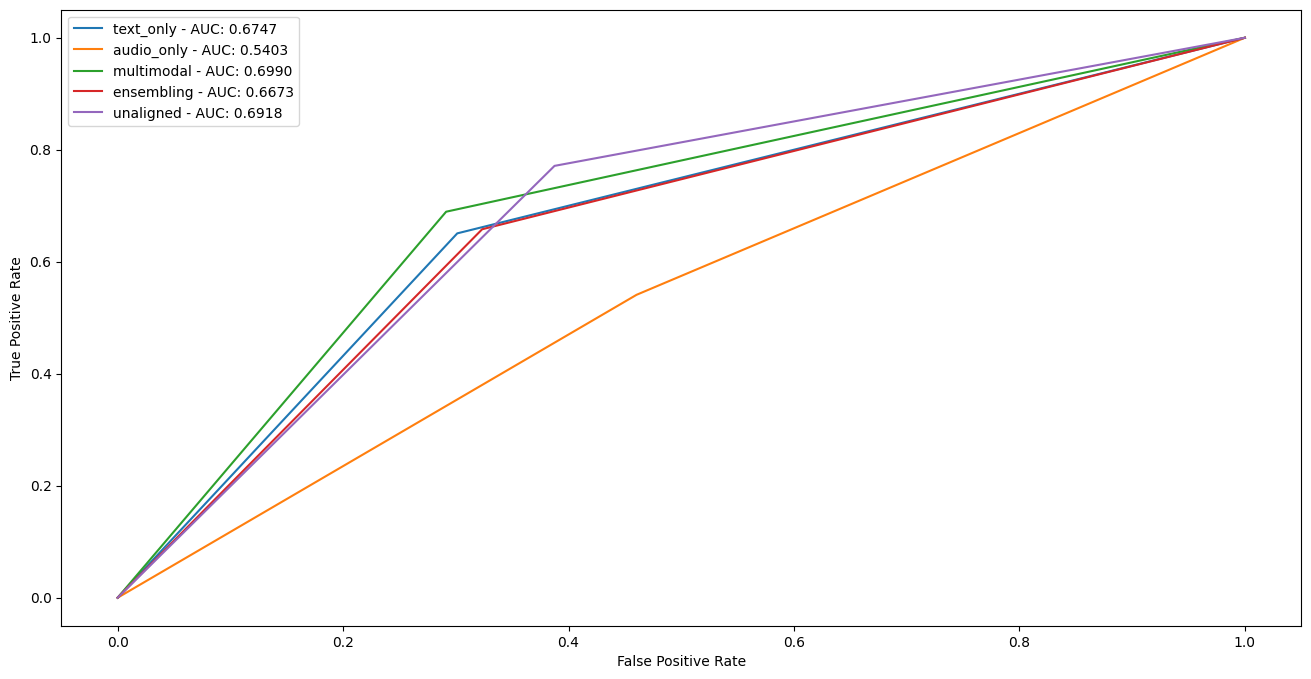

In [51]:
# plot ROC curves and compute AUC
plt.figure(figsize=(16, 8))
for model_name in test_results.keys():
    best_result = best_results[model_name]
    # compute the ROC curve
    fpr, tpr, _ = roc_curve(best_result['targ'].cpu(), best_result['pred'].cpu())
    # compute the AUC
    auc = roc_auc_score(best_result['targ'].cpu(), best_result['pred'].cpu())
    # plot the ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} - AUC: {auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Precision-Recall curves for models in best_models

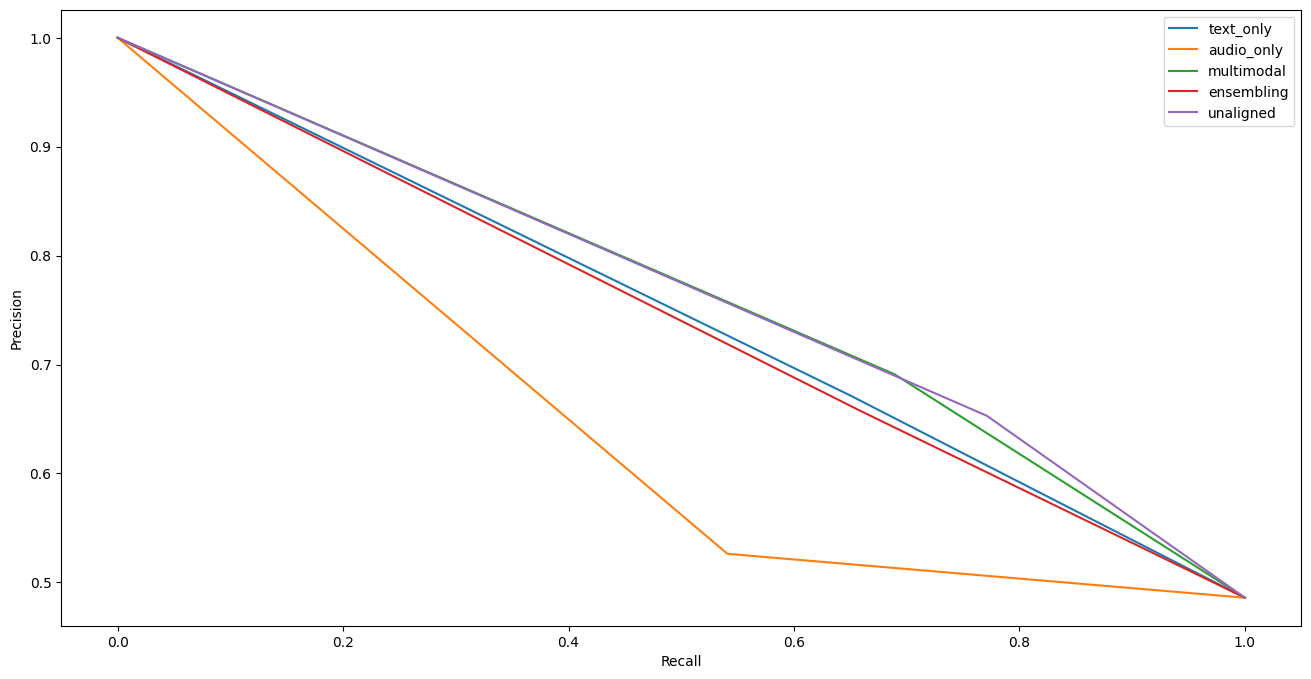

In [52]:
# plot precision-recall curves
plt.figure(figsize=(16, 8))
for model_name in test_results.keys():
    best_result = best_results[model_name]
    # compute the precision-recall curve
    precision, recall, _ = precision_recall_curve(best_result['targ'].cpu(), best_result['pred'].cpu())
    # plot the precision-recall curve
    plt.plot(recall, precision, label=f'{model_name}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Confusion Matrix for models in best_models

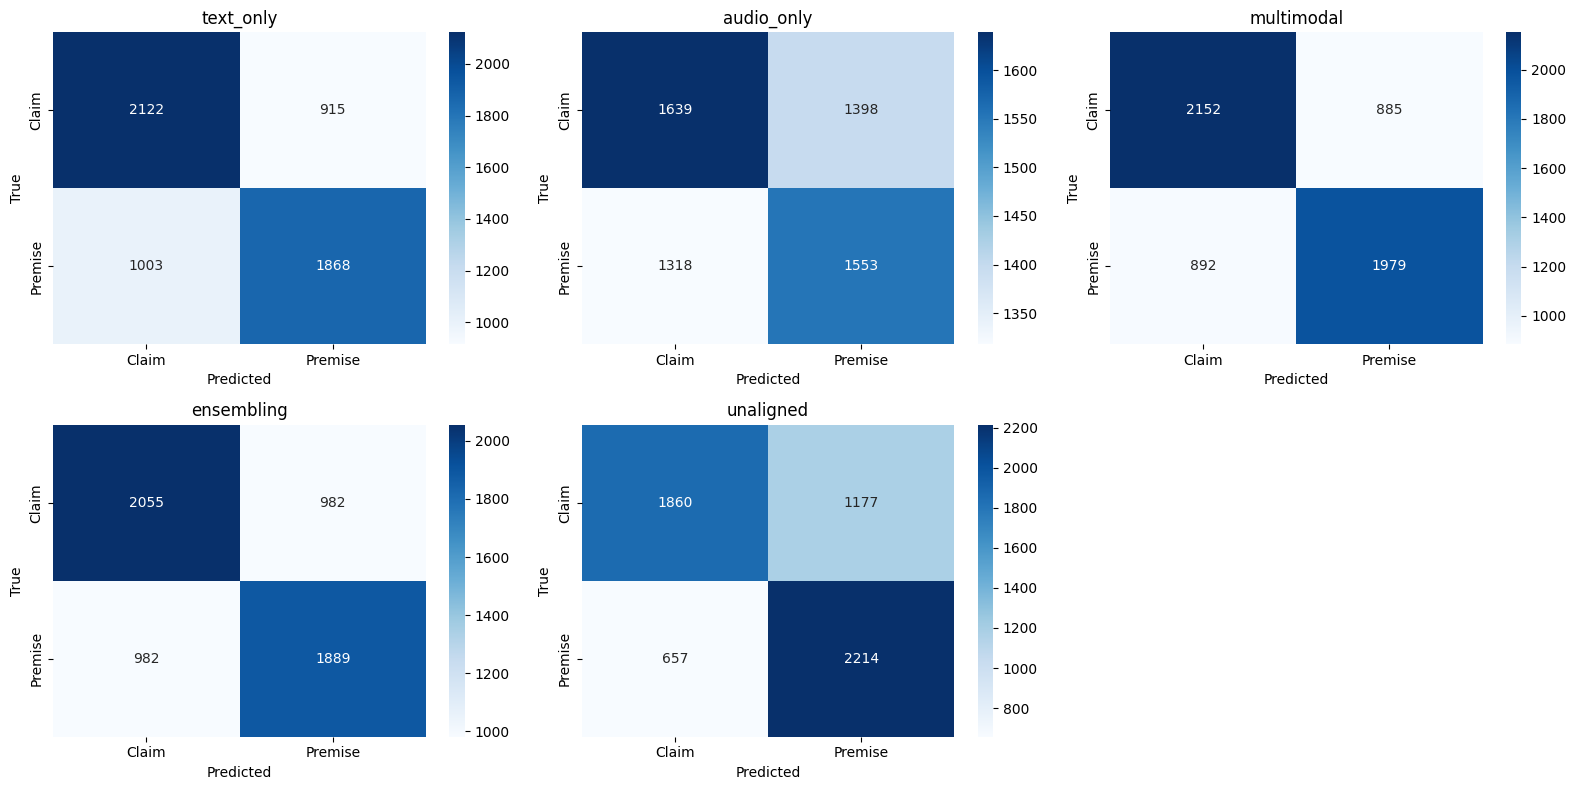

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for i, model_name in enumerate(test_results.keys()):
    best_result = best_results[model_name]
    
    cm = confusion_matrix([ID_2_LABEL[label.item()] for label in best_result['targ'].cpu()],
                      [ID_2_LABEL[label.item()] for label in best_result['pred'].cpu()])
                      
    sns.heatmap(cm, annot=True, ax=axes[i//3][i%3], fmt='d', cmap='Blues', xticklabels=['Claim', 'Premise'], yticklabels=['Claim', 'Premise'])
    axes[i//3][i%3].set_title(model_name)
    axes[i//3][i%3].set_xlabel('Predicted')
    axes[i//3][i%3].set_ylabel('True')
axes[1][2].axis('off')
plt.tight_layout()
plt.show()

# Breakdown analysis on the Best performing model

Best performing model: multimodal
Accuracy: 0.6992
F1: 0.6990
AUC: 0.6990

              precision    recall  f1-score   support

       Claim       0.71      0.71      0.71      3037
     Premise       0.69      0.69      0.69      2871

    accuracy                           0.70      5908
   macro avg       0.70      0.70      0.70      5908
weighted avg       0.70      0.70      0.70      5908



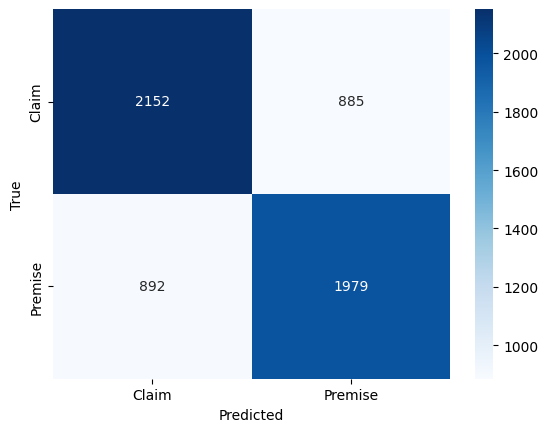

In [61]:
best_performing_model_name = max(aggregated_results_df['F1']['mean'].items(), key=lambda x: x[1])[0]

best_performing_model = max(test_results[best_performing_model_name], key=lambda x: x['f1'])

print(f'Best performing model: {best_performing_model_name}')
print(f'Accuracy: {best_performing_model["acc"]:.4f}')
print(f'F1: {best_performing_model["f1"]:.4f}')
print(f'AUC: {roc_auc_score(best_performing_model["targ"].cpu(), best_performing_model["pred"].cpu()):.4f}')
print()

print(classification_report([ID_2_LABEL[label.item()] for label in best_performing_model['targ']],
                            [ID_2_LABEL[label.item()] for label in best_performing_model['pred']])) 

cm = confusion_matrix([ID_2_LABEL[label.item()] for label in best_performing_model['targ']],
                        [ID_2_LABEL[label.item()] for label in best_performing_model['pred']])          

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Claim', 'Premise'], yticklabels=['Claim', 'Premise'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()